In [1]:
%matplotlib inline

In [2]:
%matplotlib notebook
import multiprocessing as mp
mp.set_start_method('forkserver')

In [3]:
import torch.nn.functional as F
import torch
torch.cuda.set_device(0)
import torch.nn as nn
from torch.nn.utils import weight_norm, spectral_norm
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import numpy as np
import numpy as np 
from matplotlib import pyplot as plt
from torch.optim import *
from InvertibleResnet import *

In [4]:
from torch.distributions import *
dist = 3
std = 1
ndim = 2
gaussian = Normal(0.0,std)
normal_np = gaussian.sample((20000,ndim)).numpy()

# m = Exponential(1)
# exp_np = m.sample((500,ndim)).numpy()
# print(exp_np.shape)
# normal_np = np.concatenate([normal_np,exp_np])
binomial = Binomial(1, probs=0.5)
bern_np = (binomial.sample((20000,)).numpy() - 0.5) * (dist*2)
normal_np[:,0] += bern_np
bern_np = (binomial.sample((20000,)).numpy() - 0.5) * (dist*2)
normal_np[:,1] += bern_np

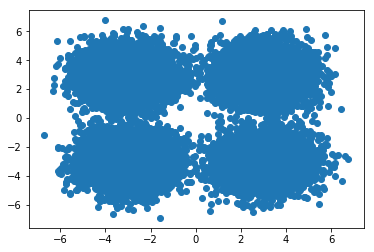

In [5]:
%matplotlib inline
plt.scatter(normal_np[:,0], normal_np[:,1])

In [6]:
dists = torch.from_numpy(np.array([[dist,-dist], [dist, dist], [-dist, dist], [-dist,-dist]]).astype(np.float32)).cuda()

<IPython.core.display.Javascript object>


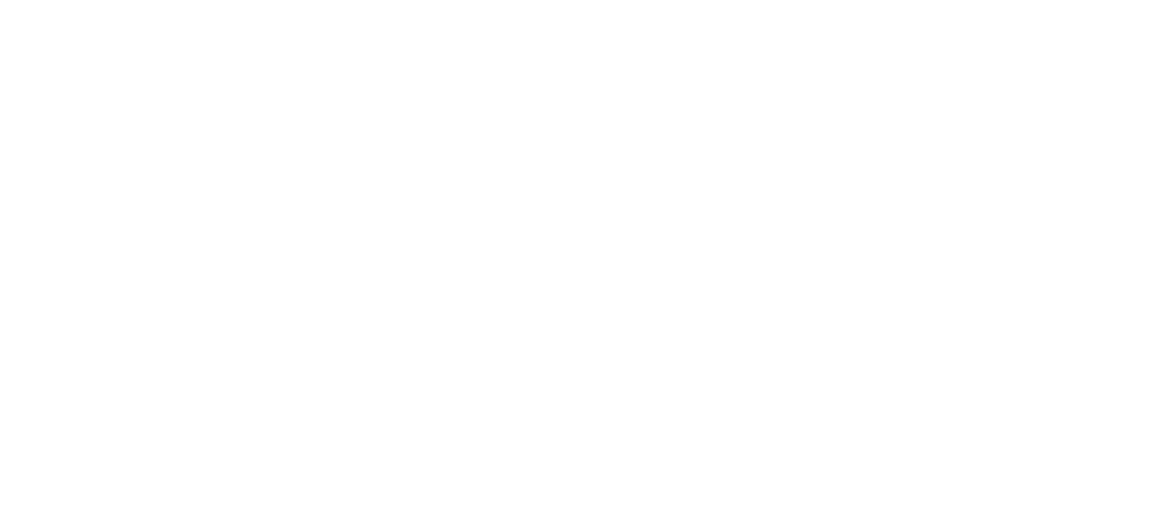

A Jupyter Widget

loss:1.7908, logdet:0.0188 pz:-1.8096 
loss:1.2911, logdet:0.1852 pz:-1.4762 
loss:0.8733, logdet:0.3429 pz:-1.2163 
loss:0.5752, logdet:0.5065 pz:-1.0817 


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


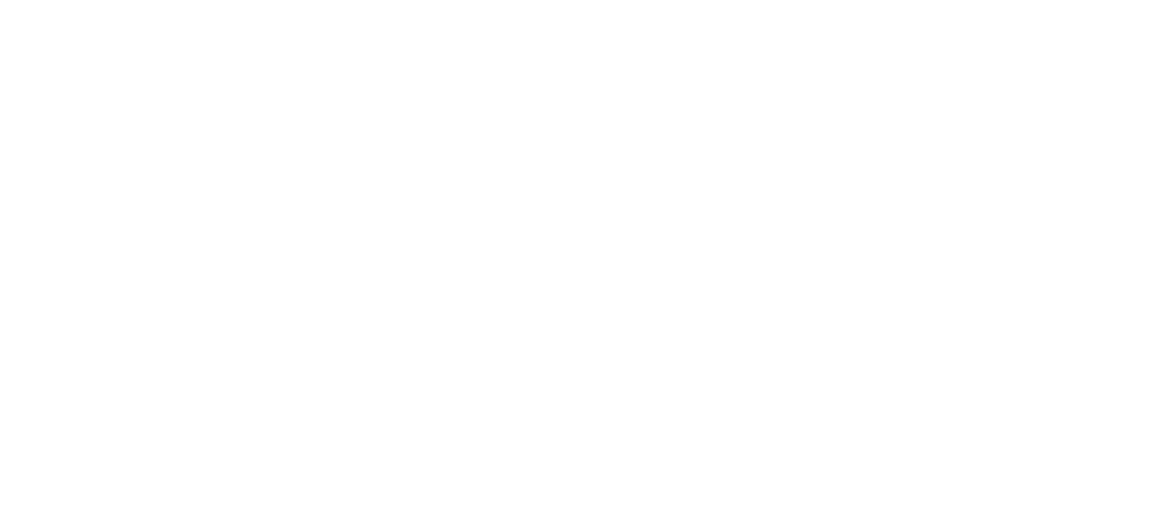

In [7]:
%matplotlib notebook
fig,(ax,ax2) = plt.subplots(1,2,figsize=(18,8))
axim = None
axscatter = None
fig.canvas.draw()
wasserstein_loss = []

use_normal = True
test_aucs = []
train_aucs = []
pred_losses = []
pzes = []
logdets = []
losses = []
latent_numpys =[]
def torchSigWMW( target,pred, beta=8):    
    mask = target.type(torch.cuda.ByteTensor)
    x = torch.masked_select(pred, 1+(-1)*mask).view(1,-1)
    y = torch.masked_select(pred, mask).view(-1,1)
    xn = x.expand(y.size(0), x.size(1))
    yn = y.expand(y.size(0), x.size(1))
    ur = torch.sigmoid(-beta*(xn-yn))
    return torch.sum(ur) / torch.sum(target) / torch.sum(1-target)

def criterion(pred, target):
    # return ((pred - (target * dist * 2 - dist)) ** 2).mean() 
    return torchSigWMW(target, pred)

net = InvertibleResnet(ndim,100,0.8, hidden_dim=64, reverse_iterations=40).cuda()
optim = Adam(net.parameters(), lr=0.0003, betas=(0.1,0.9))
for epoch in tqdm(range(0,10)):     
    for itercount in range(80):



        net.train()
        optim.zero_grad()
        latent, logdet = net(torch.randn((256,2)).cuda()  , logdet=True, num_logdet_iter=1) 
        logdet /= latent.shape[1]
        latentstd = torch.mean(latent.std(dim=0))

        pz = 0
        for d in dists:
            pz += torch.exp( -((latent - d) ** 2) / 2 )
        pz = torch.log(pz).sum(dim=1).mean()


        pz /= latent.shape[1]
        print ('loss:{:.4f}, logdet:{:.4f} pz:{:.4f} '.format(
                -logdet.item()-pz.item(), logdet.item(),pz.item()))
        ( - logdet - pz).backward()

        pzes.append(pz.item())
        logdets.append(logdet.item())
        losses.append((-logdet-pz).item())
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optim.step()

        if itercount % 10 == 0:
            net.eval()
            latents = []
            for _itercount in range(10):
                train_batch = torch.randn((256,2)).cuda()
                latent = net(train_batch, logdet=False)
                latents.extend(latent.cpu().detach().numpy())

            with torch.no_grad():
                pred = net(latent[:1], reverse=True)
            latent_numpy = np.array(latents)


            recon_loss = F.mse_loss(train_batch[:1], pred)
            if itercount >0:
                print ('loss:{:.4f}, logdet:{:.4f} pz:{:.4f} latentstd:{:.4f}  recon_loss:{:.4f}'.format(
                -logdet.item()-pz.item(), logdet.item(),pz.item(), latentstd.item(),  recon_loss.item()))



            pred_np = pred[0].cpu().detach().numpy().reshape((1,2))
            inp_np = train_batch[0].cpu().detach().numpy().reshape((1,2))
            disp = np.concatenate([pred_np, inp_np], axis=1)
            if axim:
                axim.set_data(disp)
            else:
                axim = ax.imshow(disp)


            ax2.clear()
            if itercount > 0:
                ax2.scatter(normal_np[:1000,0], normal_np[:1000,1], c='g')            
            ax2.scatter(latent_numpy[:1000,0], latent_numpy[:1000,1],  c='r')  
            fig.canvas.draw()
            latent_numpys.append(latent_numpy)
        del pz,  logdet, latent, latentstd
    #with torch.no_grad():
    #    for name, param in net.named_parameters():
    #        if '.weight' in name:
    #            param /= torch.sqrt((param ** 2).sum())

In [ ]:
latent_numpys = np.array(latent_numpys)

In [ ]:
latent_numpys.shape

In [ ]:
latent_numpys = latent_numpys.reshape((-1,80,2560,2))

In [ ]:
latent_numpy = latent_numpys[0,-1]

In [ ]:
latent_numpy.shape

In [ ]:
np.std(latent_numpy[np.logical_and(latent_numpy[:,0] > 0, latent_numpy[:,1] < 0)], axis=0)

In [ ]:
np.mean(latent_numpy[np.logical_and(latent_numpy[:,0] < 0, latent_numpy[:,1] < 0)], axis=0)

In [ ]:
%matplotlib notebook
fig,ax =  plt.subplots(1,1,figsize=(8,8))
def scroll(event):
    global i, latent_numpys
    oldi = i
    if event.key == 'e':
        i -= 1
    elif event.key =='d':
        i += 1
    if i < 0: i = 0
    if i >= len(latent_numpys[0]) - 0: i = len(latent_numpys[0]) - 1
    if oldi != i:
        ax.clear()
        latent_numpy = latent_numpys[0][i][-1]
        
        ax.clear()
        _ = ax.hist(latent_numpys[0][i][:,1], bins=100, density=True)
        _ = ax.hist(normal_np[:,1], bins=100, density=True)
        
        fig.canvas.draw()
        #ax.set_xlim(-3,3)
        #ax.set_ylim(-3,3)


cid1 = fig.canvas.mpl_connect('key_press_event', scroll)
i = 0
latent_numpy = latent_numpys[0][i][-1]
ax.clear()
_ = ax.hist(latent_numpys[0][i][:,1], bins=100, density=True)
_ = ax.hist(normal_np[:,1], bins=100, density=True)


fig.canvas.draw()
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)


In [ ]:
%matplotlib notebook
fig,ax =  plt.subplots(1,1,figsize=(8,8))
def scroll(event):
    global i, latent_numpys
    oldi = i
    if event.key == 'e':
        i -= 1
    elif event.key =='d':
        i += 1
    if i < 0: i = 0
    if i >= len(latent_numpys[0]) - 0: i = len(latent_numpys[0]) - 1
    if oldi != i:
        ax.clear()
        latent_numpy = latent_numpys[0,i]
        
        ax.clear()
        ax.scatter(normal_np[:,0], normal_np[:,1], c='g') 
        ax.scatter(latent_numpy[:500,0], latent_numpy[:500,1],  c='r')  
        fig.canvas.draw()
        #ax.set_xlim(-3,3)
        #ax.set_ylim(-3,3)


cid1 = fig.canvas.mpl_connect('key_press_event', scroll)
i = 0
latent_numpy = latent_numpys[0,i]
ax.clear()
ax.scatter(normal_np[:,0], normal_np[:,1], c='g')
ax.scatter(latent_numpy[:500,0], latent_numpy[:500,1],  c='r')  
fig.canvas.draw()
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)

In [ ]:
%matplotlib inline
plt.plot(range(len(losses[:])), losses[:])

In [ ]:
%matplotlib inline
plt.plot(range(len(logdets[:])), logdets[:])

In [ ]:
%matplotlib inline
plt.plot(range(len(pzes[250:])), pzes[250:])